# Underfitting / overfitting tradeoff with spline-based Poisson regression

In [4]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

In [31]:
X = np.random.uniform(0, 4.5 * 2 * np.pi, size=1000).reshape(-1, 1)

def ground_truth_mean(x):
    return np.sin(x) + x / 10. + 1

y = stats.lognorm.rvs(1., loc=ground_truth_mean(X.ravel()), scale=ground_truth_mean(X.ravel()) / 2)


Text(0.5, 1.0, 'Operation profile of a rotating machine')

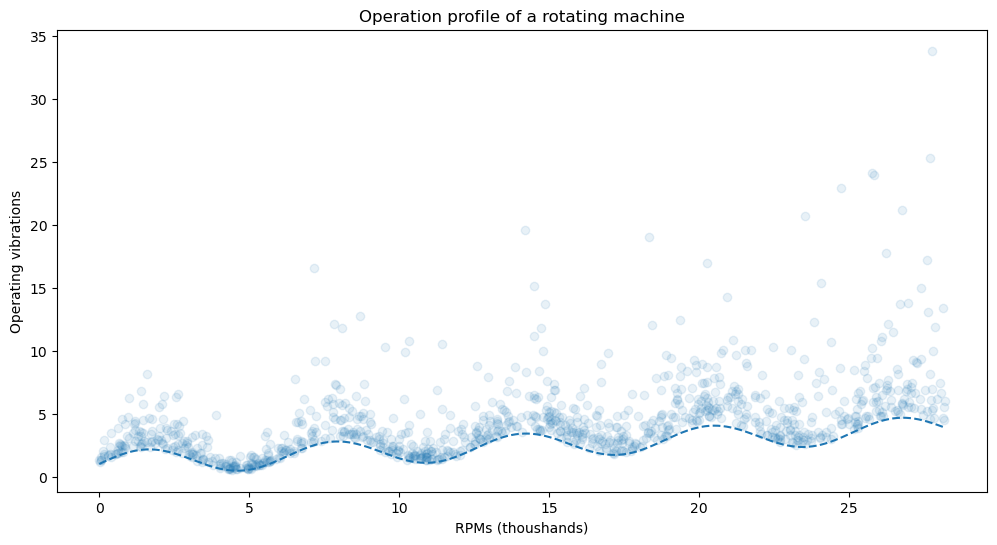

In [43]:
plt.figure(figsize=(12, 6))

plt.scatter(X.ravel(), y, alpha=0.1)

x_grid = np.linspace(X.min(), X.max(), 1000)
# plt.plot(x_grid, ground_truth_mean(x_grid), "--", label="Mean")

plt.ylabel("Operating vibrations")
plt.xlabel("RPMs (thoushands)")
plt.title("Operation profile of a rotating machine")

In [33]:
from sklearn.model_selection import validation_curve
from sklearn.model_selection import ShuffleSplit


def plot_prediction_function(model, X, y, param_name, param_range, short_name=None, title=None, ax=None):
    if ax is None:
        _, ax = plt.subplots(figsize=(12, 6))
    ax.scatter(X.ravel(), y, alpha=0.1)
    if short_name is None:
        short_name = param_name.rsplit("__", 1)[1] if "__" in param_name else param_name

    X_test = np.linspace(X.min(), X.max(), 1000).reshape(-1, 1)
    for param_value in param_range:
        model.set_params(**{param_name: param_value})
        model.fit(X, y)
        ax.plot(X_test.ravel(), model.predict(X_test), label=f"prediction for {short_name}={param_value}")
    ax.set(
        xlabel="X",
        ylabel="y",
        title=title,
    )
    ax.legend()


def plot_validation_curve(model, X, y, param_name, param_range, ax=None):
    if ax is None:
        _, ax = plt.subplots(figsize=(12, 6))
    short_name = param_name.rsplit("__", 1)[1] if "__" in param_name else param_name

    cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
    train_scores, test_scores = validation_curve(
        model,
        X,
        y,
        param_name=param_name,
        param_range=param_range,
        cv=cv,
    )
    ax.semilogx(param_range, train_scores.mean(axis=1), label="train")
    ax.semilogx(param_range, test_scores.mean(axis=1), label="test")
    ax.set_xticks(param_range, param_range)
    ax.set_xlabel(short_name)
    ax.set_ylabel("R2 - higher is better")
    ax.legend()
    

In [34]:
from sklearn.preprocessing import SplineTransformer
from sklearn.linear_model import PoissonRegressor
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline


spline_reg = make_pipeline(
    SplineTransformer(),
    PoissonRegressor(alpha=1e-4, max_iter=1000),
)

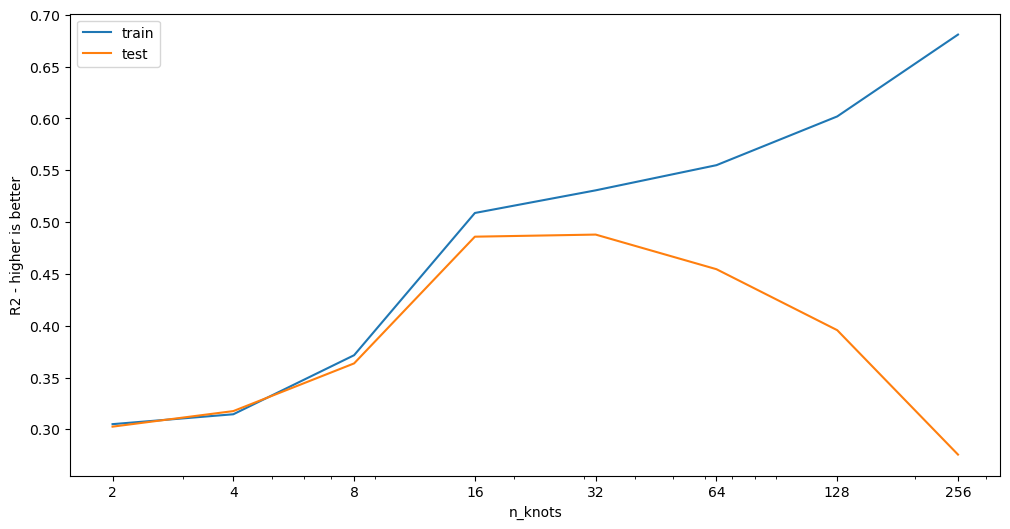

In [37]:
param_range = [2, 4, 8, 16, 32, 64, 128, 256]
plot_validation_curve(spline_reg, X, y, param_name="splinetransformer__n_knots", param_range=param_range)

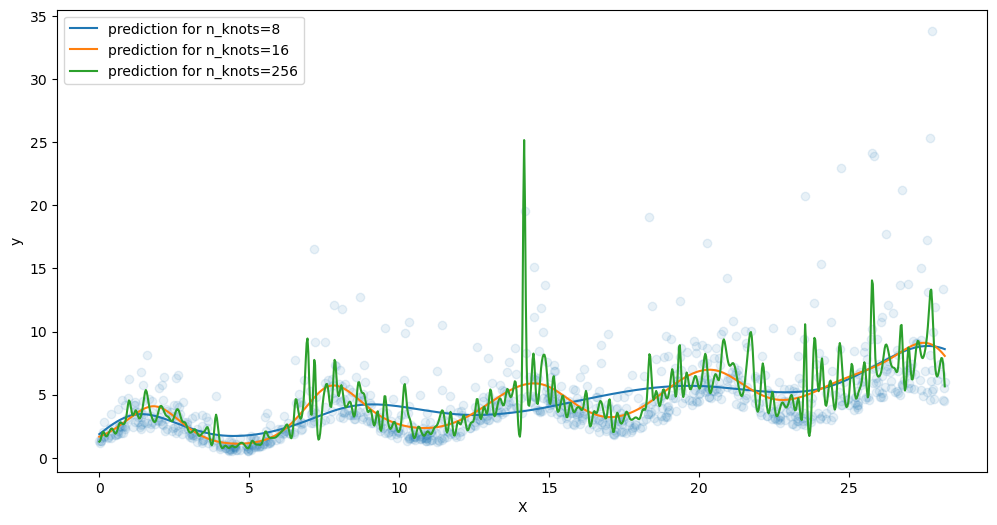

In [39]:
plot_prediction_function(spline_reg, X, y, "splinetransformer__n_knots", [8, 16, 256])

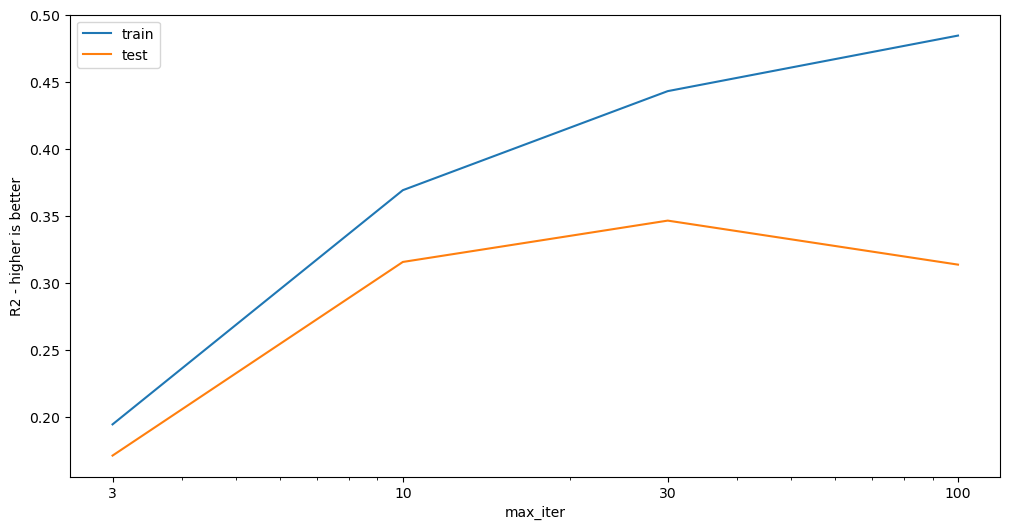

In [40]:
from sklearn.ensemble import HistGradientBoostingRegressor


gbrt = HistGradientBoostingRegressor(loss="poisson")
plot_validation_curve(gbrt, X, y, param_name="max_iter", param_range=[3, 10, 30, 100])

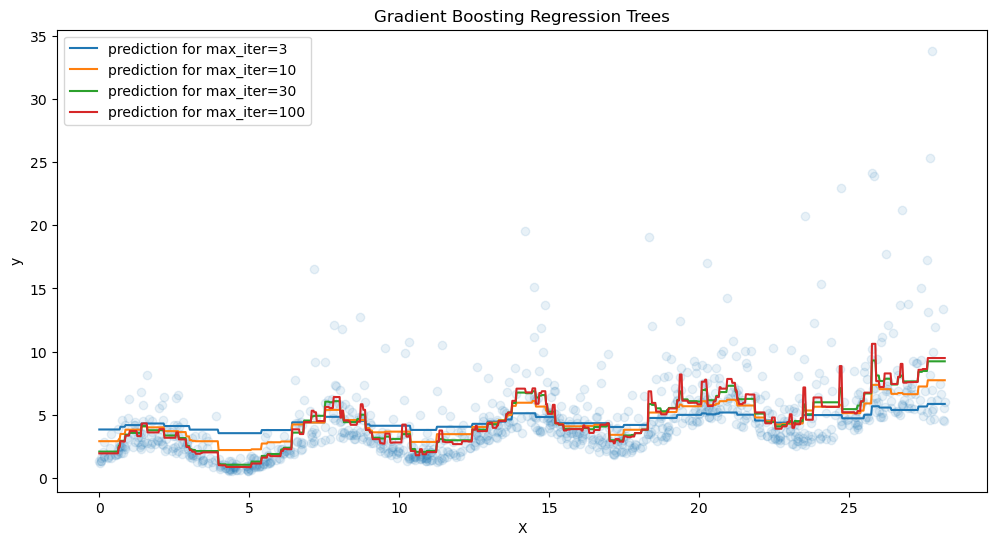

In [41]:
plot_prediction_function(gbrt, X, y, "max_iter", [3, 10, 30, 100], title="Gradient Boosting Regression Trees")